## **Explainable AI in Time Series Data**

In [1]:
from pathlib import Path
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
print("PROJECT_ROOT:", PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))

PROJECT_ROOT: /Users/sarataboas/Desktop/master/ai_society/individual_assignment/socialCrisis_prediction


In [2]:
from src.models.train_utils import load_data, split_data, scale_data, create_time_windows
from src.explainability.explainability_utils import *

/Users/sarataboas/Desktop/master/ai_society/individual_assignment/socialCrisis_prediction/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
DATA_PATH   = PROJECT_ROOT / "datasets" / "data_merged.csv"
MODEL_PATH  = PROJECT_ROOT / "outputs" / "lstm_class_weights_model.h5"
SCALER_PATH = PROJECT_ROOT / "outputs" / "scaler_class_weights.save"

N_STEPS = 4
TARGET_COL = "label"


### **Experimental Setup**

In [4]:
df = load_data(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date') 

feature_names = [c for c in df.columns if c not in ["label"]]

print("N features:", len(feature_names))
print("Features:", feature_names)


N features: 11
Features: ['GDP_diff', 'UNRATE', 'CPI_diff', 'INDPRO_diff', 'DFF_diff', 'DGS10_diff', 'DGS2_diff', 'T10Y2Y', 'VIX', 'DTB3_diff', 'NEWS_SENTIMENT']


In [5]:
df_train, df_test = split_data(df, train_size=0.8)

print("Train rows:", len(df_train))
print("Test rows :", len(df_test))

Train rows: 113
Test rows : 29


In [6]:
df_train, df_test, scaler = scale_data(df_train, df_test, scaler_path=SCALER_PATH, target_col=TARGET_COL)

Scaler saved in /Users/sarataboas/Desktop/master/ai_society/individual_assignment/socialCrisis_prediction/outputs/scaler_class_weights.save


In [7]:
X_train, y_train = create_time_windows( df_train, n_steps=N_STEPS, target_col=TARGET_COL)
X_test, y_test = create_time_windows( df_test, n_steps=N_STEPS, target_col=TARGET_COL)
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

X_train: (109, 4, 11)
X_test : (25, 4, 11)


In [8]:
model = keras.models.load_model( MODEL_PATH, compile=False)
print("Model loaded")
print("Input shape :", model.input_shape)
print("Output shape:", model.output_shape)

Model loaded
Input shape : (None, 8, 11)
Output shape: (None, 1)


In [9]:
preds = model.predict(X_test, verbose=0)

preds = np.asarray(preds)
if preds.ndim == 1:
    preds = preds.reshape(-1, 1)

print("Preds shape:", preds.shape)
print("Preds min/max:", preds.min(), preds.max())

Preds shape: (25, 1)
Preds min/max: 0.088895485 0.5976973


In [10]:
threshold = 0.5
pred_labels = (preds[:, 0] > threshold).astype(int)

tp_idxs = np.where((y_test == 1) & (pred_labels == 1))[0]
fp_idxs = np.where((y_test == 0) & (pred_labels == 1))[0]
tn_idxs = np.where((y_test == 0) & (pred_labels == 0))[0]
fn_idxs = np.where((y_test == 1) & (pred_labels == 0))[0]

print(f"TP: {len(tp_idxs)} | FP: {len(fp_idxs)} | TN: {len(tn_idxs)} | FN: {len(fn_idxs)}")


instances = {
    "TP": int(tp_idxs[np.argmax(preds[tp_idxs, 0])]) if len(tp_idxs) > 0 else None,
    "FP": int(fp_idxs[np.argmax(preds[fp_idxs, 0])]) if len(fp_idxs) > 0 else None,
    "TN": int(tn_idxs[np.argmin(preds[tn_idxs, 0])]) if len(tn_idxs) > 0 else None,
    "FN": int(fn_idxs[np.argmax(preds[fn_idxs, 0])]) if len(fn_idxs) > 0 else None,
}

print("Selected instances:", instances)


TP: 2 | FP: 4 | TN: 19 | FN: 0
Selected instances: {'TP': 3, 'FP': 24, 'TN': 7, 'FN': None}


### **Integrated Gradients**

In [11]:
from alibi.explainers import IntegratedGradients

In [12]:
baseline = np.zeros_like(X_test[:1])
print(baseline.shape)

(1, 4, 11)


In [13]:
ig_explainer = IntegratedGradients(
    model,
    layer=None,       
    method="gausslegendre",
    n_steps=64        
)

In [14]:
idx = instances["TP"]   # ou FP / TN
x = X_test[idx:idx+1]

explanation = ig_explainer.explain(x, baselines=baseline, target=1)
ig_tp = explanation.attributions[0]   # shape (T, F)
ig_tp = ig_tp[0]   # agora (4, 11)


2026-01-03 13:33:52.749970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


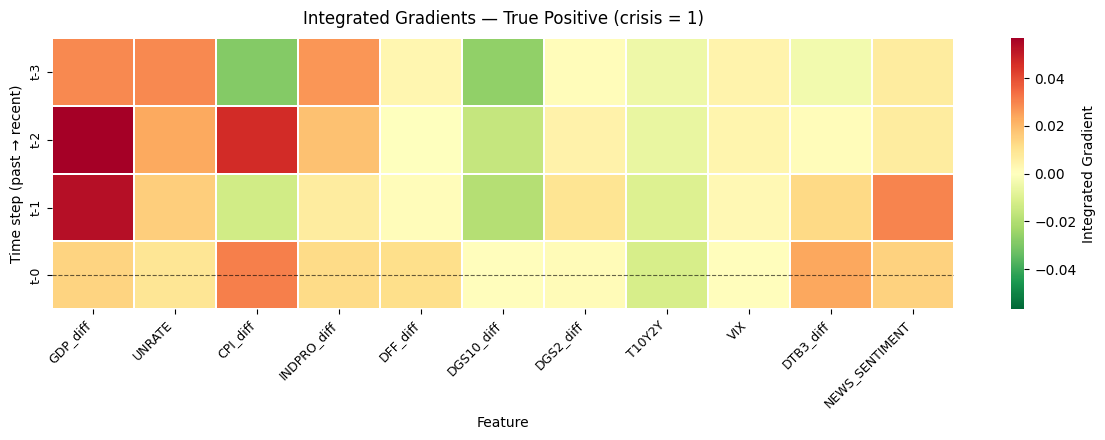

In [15]:
plot_ig_heatmap(ig_tp, feature_names, "Integrated Gradients — True Positive (crisis = 1)")

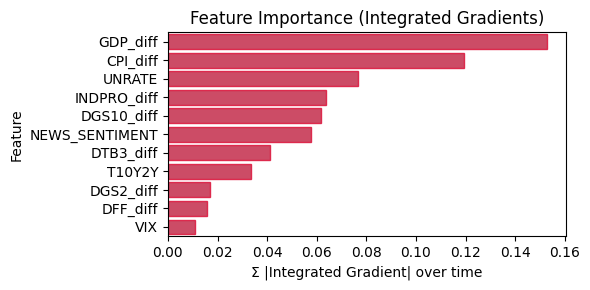

In [16]:
plot_ig_feature_importance(ig_tp, feature_names)

In [17]:
idx = instances["FP"]   # ou FP / TN
x = X_test[idx:idx+1]

explanation = ig_explainer.explain(x, baselines=baseline, target=1)
ig_fp = explanation.attributions[0]   # shape (T, F)
ig_fp = ig_fp[0]   # agora (4, 11)


2026-01-03 13:33:52.973020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


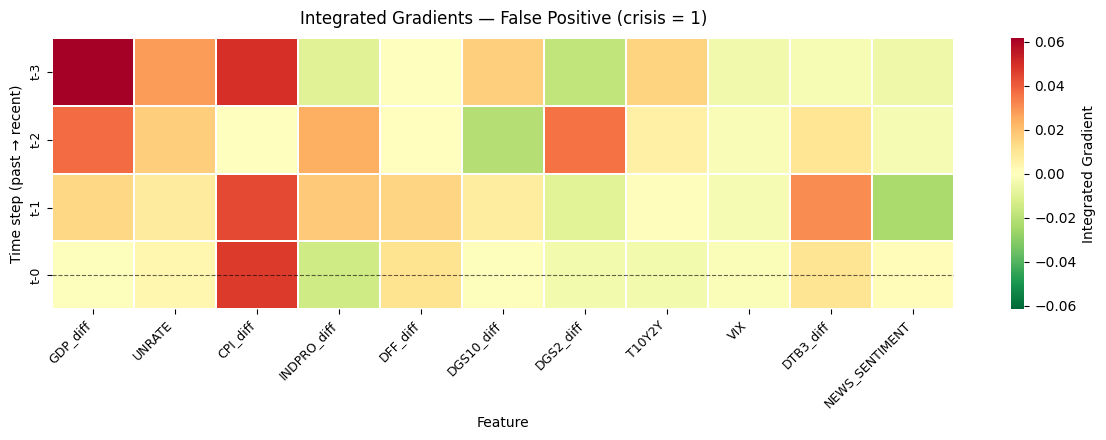

In [18]:
plot_ig_heatmap(ig_fp, feature_names, "Integrated Gradients — False Positive (crisis = 1)")

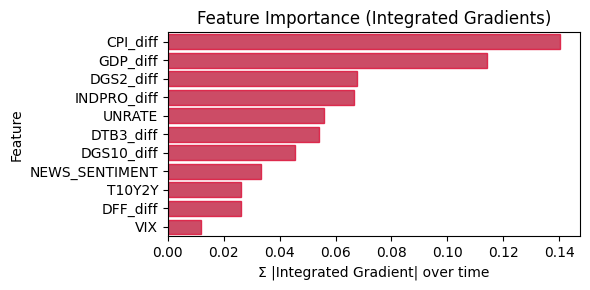

In [19]:
plot_ig_feature_importance(ig_fp, feature_names)

In [20]:
idx = instances["TN"]   # ou FP / TN
x = X_test[idx:idx+1]

explanation = ig_explainer.explain(x, baselines=baseline, target=0)
ig_tn = explanation.attributions[0]   # shape (T, F)
ig_tn = ig_tn[0]   # agora (4, 11)


2026-01-03 13:33:53.175174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


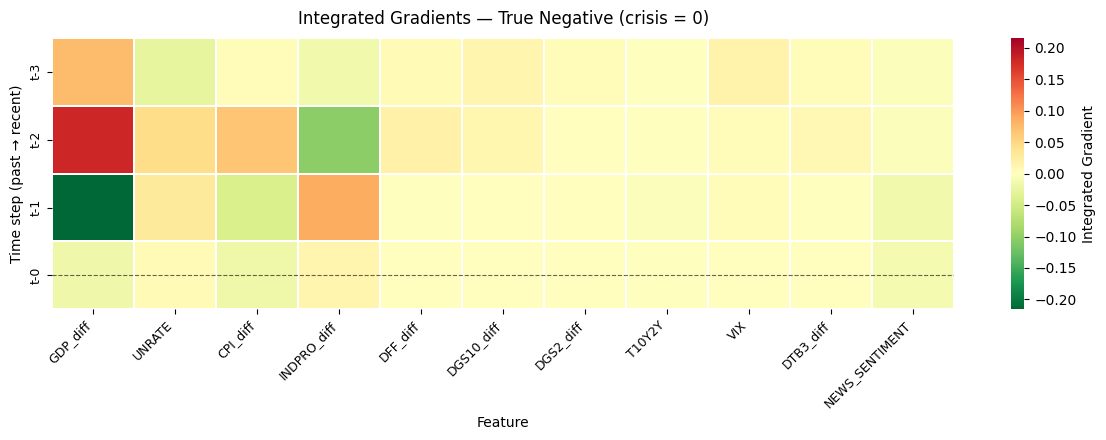

In [21]:
plot_ig_heatmap(ig_tn, feature_names, "Integrated Gradients — True Negative (crisis = 0)")

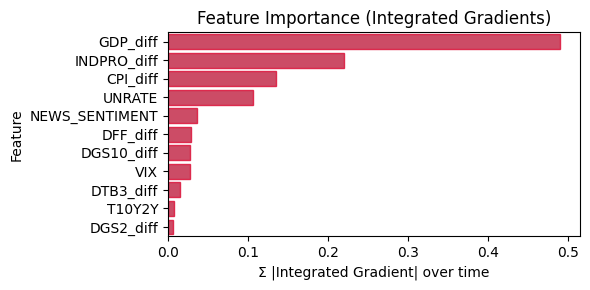

In [22]:
plot_ig_feature_importance(ig_tn, feature_names)

### **Occlusion-based Explainability**

In [23]:
idx = instances["TP"]   # ou FP / TN
x = X_test[idx:idx+1]
occlusion_map_tp = occlusion_feature_time(model, x)

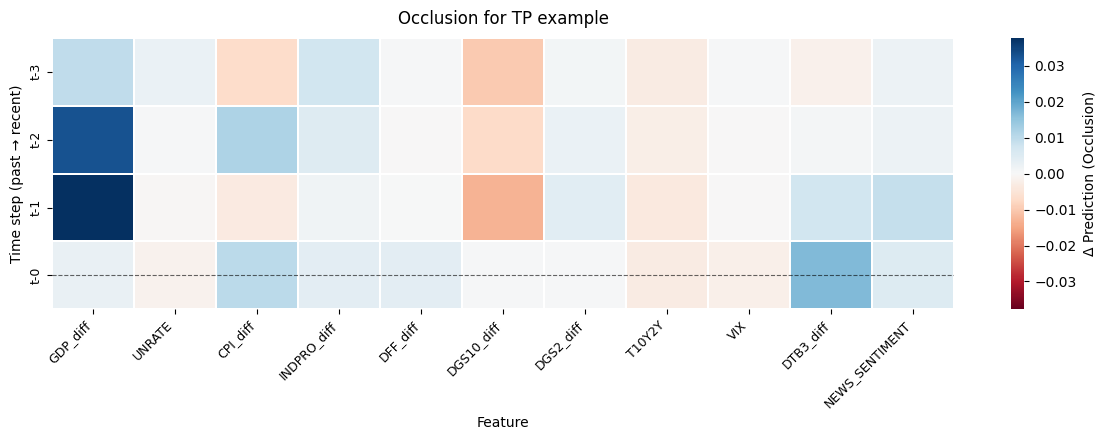

In [24]:
plot_occlusion_heatmap(occlusion_map_tp, feature_names, 'Occlusion for TP example')

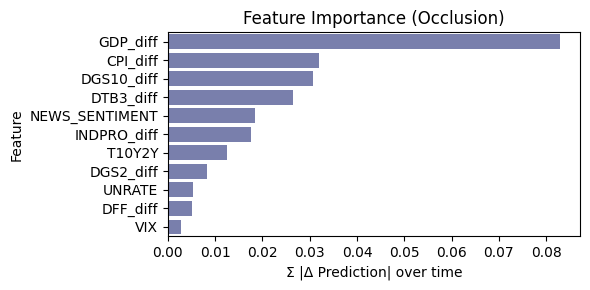

In [25]:
plot_occlusion_feature_importance(occlusion_map_tp, feature_names)

In [26]:
idx = instances["FP"]   # ou FP / TN
x = X_test[idx:idx+1]
occlusion_map_fp = occlusion_feature_time(model, x)

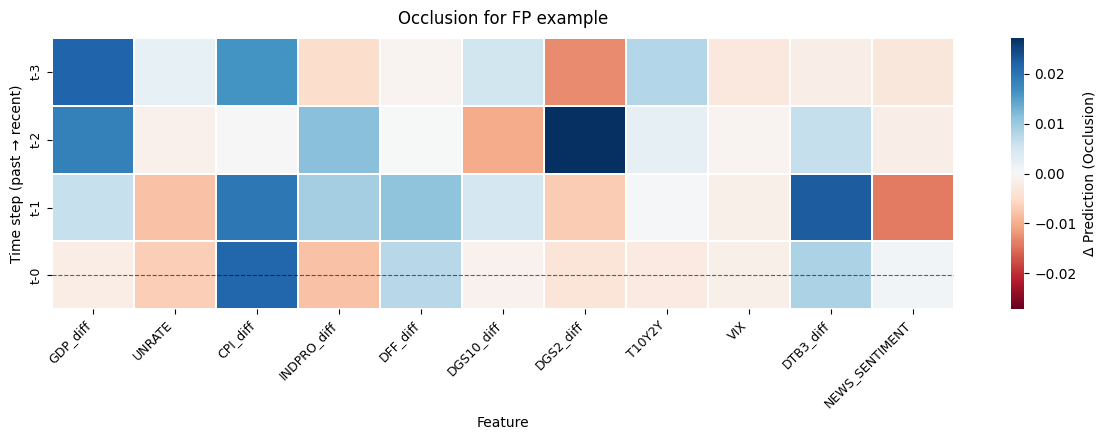

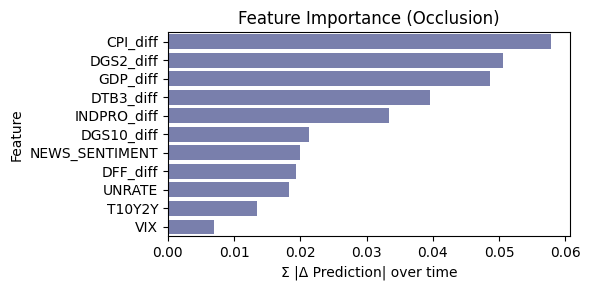

In [27]:
plot_occlusion_heatmap(occlusion_map_fp, feature_names, 'Occlusion for FP example')
plot_occlusion_feature_importance(occlusion_map_fp, feature_names)

In [28]:
idx = instances["TN"]   # ou FP / TN
x = X_test[idx:idx+1]
occlusion_map_tn = occlusion_feature_time(model, x)

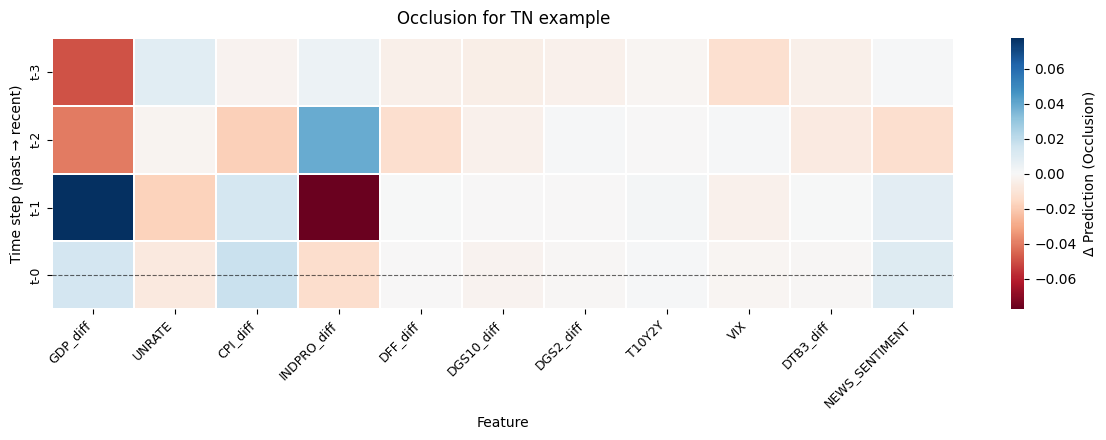

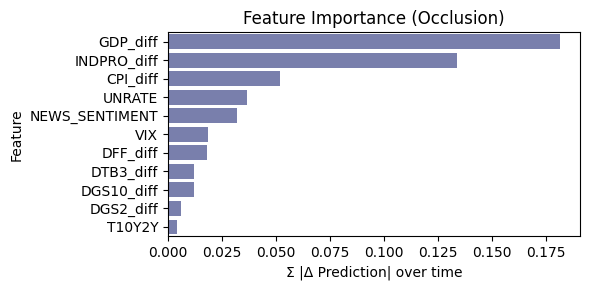

In [29]:
plot_occlusion_heatmap(occlusion_map_tn, feature_names, 'Occlusion for TN example')
plot_occlusion_feature_importance(occlusion_map_tn, feature_names)

### **LIME**

In [31]:
lime_feature_names = []
T, F = X_test.shape[1], X_test.shape[2]
for t in range(T):
    for f in feature_names:
        lime_feature_names.append(f"{f}@t-{T-1-t}")


In [32]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)

explainer = LimeTabularExplainer(
    X_train_flat,
    feature_names=lime_feature_names,
    class_names=["no_crisis", "crisis"],
    mode="classification",
    discretize_continuous=False
)


In [33]:
idx = instances["TP"]  # ou FP / TN
x_flat = X_test[idx].reshape(-1)

lime_exp = explainer.explain_instance(
    x_flat,
    lambda Z: lime_predict_fn(Z, X_test, model),
    num_features=10,
    top_labels=1
)


In [34]:
df_lime = lime_to_dataframe(lime_exp, label=1)
df_lime


,feature,weight,abs_weight
0,CPI_diff@t-3,0.053097,0.053097
1,CPI_diff@t-2,0.044691,0.044691
2,UNRATE@t-3,-0.030859,0.030859
3,CPI_diff@t-0,0.027613,0.027613
4,UNRATE@t-2,-0.027302,0.027302
5,UNRATE@t-1,-0.022921,0.022921
6,INDPRO_diff@t-3,-0.022015,0.022015
7,GDP_diff@t-2,0.018819,0.018819
8,UNRATE@t-0,-0.015700,0.015700
9,GDP_diff@t-1,0.012320,0.012320


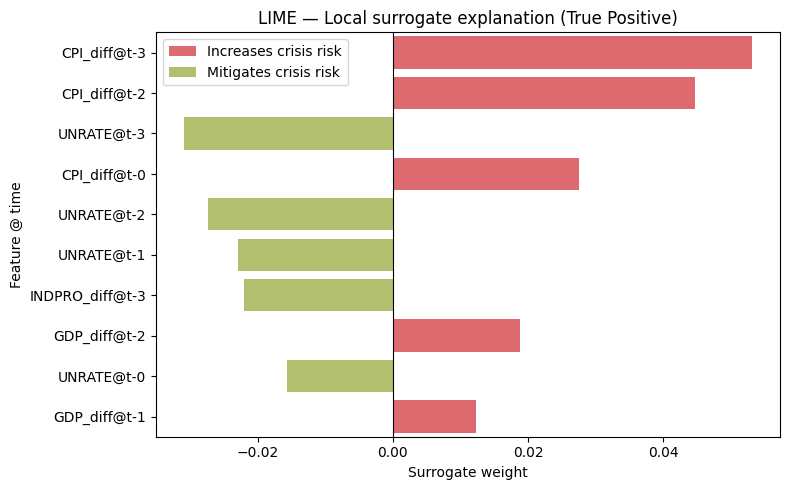

In [35]:
plot_lime_surrogate(
    df_lime,
    title="LIME — Local surrogate explanation (True Positive)",
    max_features=10
)


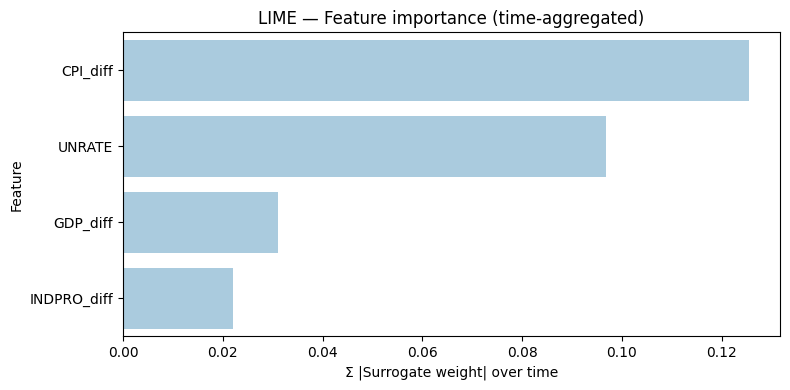

In [36]:
plot_lime_by_feature(df_lime)